In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from KernelRidge_commutator import generate_CM, KRR_commutator, KRR_commutator_with_eig, p_distance_commutator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import multiprocessing
import numba

## Load Data ##

In [2]:
data = np.load('qm9_data.npz', allow_pickle=True)
coords = data['coordinates'][:5000]
nuclear_charges = data['charges'][:5000]
elements = data['elements'][:5000]
energies = np.array(data['H_atomization'][:5000])

In [3]:
num_mol = energies.shape[0]
cm = np.zeros((num_mol, 29, 29))
for i in range(num_mol):
    cm[i] = generate_CM(coords[i], nuclear_charges[i], pad=29)

print(cm.shape)

(5000, 29, 29)


In [4]:
cm_flatten = cm.reshape((cm.shape[0], -1))
print(cm_flatten.shape)

(5000, 841)


## Model ##

In [62]:
X = cm[:2000]
y = energies.reshape(-1, 1)[:2000]
params = {'lambda': 7.882813671669788e-12, 'length': 0.7310621690634572}
mae_scores = []

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    preds = KRR_commutator(X_train, y_train, X_test, params, kernel='rbf')
    score = mean_absolute_error(preds.reshape(-1, 1), y_test)
    mae_scores.append(score)
    print(f"fold {fold+1}: MAE = {score}")

print(f"Average MAE: {np.array(mae_scores).mean()}")


fold 1: MAE = 2.141614097000082
fold 2: MAE = 2.135183672000079
Average MAE: 2.1383988845000808


In [5]:
X = cm[:2000]
y = energies.reshape(-1, 1)[:2000]
params = {'lambda': 7.882813671669788e-12, 'length': 0.7310621690634572}
mae_scores = []

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    preds = KRR_commutator_with_eig(X_train, y_train, X_test, params, kernel='rbf')
    score = mean_absolute_error(preds.reshape(-1, 1), y_test)
    mae_scores.append(score)
    print(f"fold {fold+1}: MAE = {score}")

print(f"Average MAE: {np.array(mae_scores).mean()}")


fold 1: MAE = 2.141614097000082
fold 2: MAE = 2.135183672000079
Average MAE: 2.1383988845000808


In [6]:
X = cm[:4000]
y = energies.reshape(-1, 1)[:4000]
params = {'lambda': 7.882813671669788e-12, 'length': 0.7310621690634572}
mae_scores = []

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    preds = KRR_commutator_with_eig(X_train, y_train, X_test, params, kernel='rbf')
    score = mean_absolute_error(preds.reshape(-1, 1), y_test)
    mae_scores.append(score)
    print(f"fold {fold+1}: MAE = {score}")

print(f"Average MAE: {np.array(mae_scores).mean()}")


fold 1: MAE = 2.2038203260000944
fold 2: MAE = 2.191508865000092
Average MAE: 2.1976645955000933


In [ ]:
X = cm[:2000]
y = energies.reshape(-1, 1)[:2000]

def objective(params):
    mae_scores = []
    kfold = KFold(n_splits=2, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        preds = KRR_commutator(X_train, y_train, X_test, params, kernel='rbf')
        if type(preds) is str:
            return np.inf
        score = mean_absolute_error(preds.reshape(-1, 1), y_test)
        mae_scores.append(score)
    return np.array(mae_scores).mean()

space = {
    'lambda': hp.loguniform('lambda', -30, 0), 
    'length': hp.loguniform('length', -2, 2)
}

trials = Trials()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest, # tree parzen estimator
                max_evals=50,
                trials=trials)

print("Best hyperparameters:", best)
print("Loss:", trials.best_trial['result']['loss'])

In [ ]:
def objective(params):
    mae_scores = []
    kfold = KFold(n_splits=2, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        preds = KRR_commutator(X_train, y_train, X_test, params, kernel='laplacian')
        if type(preds) is str:
            return np.inf
        score = mean_absolute_error(preds.reshape(-1, 1), y_test)
        mae_scores.append(score)
    return np.array(mae_scores).mean()

space = {
    'lambda': hp.loguniform('lambda', -30, 0), 
    'length': hp.loguniform('length', -2, 2)
}

trials = Trials()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest, # tree parzen estimator
                max_evals=50,
                trials=trials)

print("Best hyperparameters:", best)
print("Loss:", trials.best_trial['result']['loss'])

## Baseline ##

In [ ]:
X = cm_flatten[:2000]
y = energies.reshape(-1, 1)[:2000]

params = {'alpha': 1e-5, 'gamma': 1e-5, 'kernel': 'rbf'}
model = KernelRidge(**params)

neg_mae_scores = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error', cv=2)
mae_scores = -neg_mae_scores
print(mae_scores.mean())


## Learning Curve ##

In [5]:
def p_distance_eigval(X,Y):
    a, b = len(X), len(Y)
    mat = np.zeros((a,b))
    for i in range(a):
        for j in range(b):
            d_eig = np.linalg.eigvals(X[i]) - np.linalg.eigvals(Y[j])
            mat[i][j] = np.linalg.norm(d_eig)
    return mat

def p_distance_eigval_batch(X, Y, batch_size=100):
    a, b = len(X), len(Y)
    mat = np.zeros((a,b))
    print(a, b)
    for i in range(0, a, batch_size):
        for j in range(0, b, batch_size):
            end_idx_i = min(i + batch_size, a)
            end_idx_j = min(j + batch_size, b)  
            eigvals_X = np.linalg.eigvals(X[i:end_idx_i])
            eigvals_Y = np.linalg.eigvals(Y[j:end_idx_j])
            eigvals_X = eigvals_X[:, np.newaxis, :]
            eigvals_Y = eigvals_Y[np.newaxis, :, :]
            d_eig = eigvals_X - eigvals_Y
            mat_batch = np.linalg.norm(d_eig, axis=2)
            mat[i:end_idx_i, j:end_idx_j] = mat_batch
    return mat

In [7]:
X = cm
y = energies.reshape(-1, 1)

error1 = [] # commutator norm only
error2 = [] # commutator plus eigenvalue
training_size = [i*1000 for i in [1, 2, 4]]

best_params = {'lambda': 7.882813671669788e-12, 'length': 0.7310621690634572}

for size in training_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-size/5000, random_state=42)
    pred1 = KRR_commutator(X_train, y_train, X_test, best_params, kernel='rbf')
    pred2 = KRR_commutator_with_eig(X_train, y_train, X_test, best_params, kernel='rbf')
    score1 = mean_absolute_error(pred1.reshape(-1, 1), y_test)
    score2 = mean_absolute_error(pred2.reshape(-1, 1), y_test)
    error1.append(score1)
    error2.append(score2)
    score1 = np.inf
    print(f"Training size: {size}. Commutator MAE: {score1}. Commutator + Eigval MAE: {score2}")

print(error1)
print(error2)

Training size: 1000. Commutator MAE: inf. Commutator + Eigval MAE: 2.223485323750093
Training size: 2000. Commutator MAE: inf. Commutator + Eigval MAE: 2.227697762000094
Training size: 4000. Commutator MAE: inf. Commutator + Eigval MAE: 2.223716049000092
[2.223485323750093, 2.227697762000094, 2.223716049000092]
[2.223485323750093, 2.227697762000094, 2.223716049000092]


In [8]:
X = cm_flatten
y = energies.reshape(-1, 1)

normal_KRR_error = []
training_size = [i*1000 for i in [1, 2, 4]]

best_params = {'alpha': 1e-5, 'gamma': 1e-5, 'kernel': 'rbf'}

for size in training_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-size/10000, random_state=42)
    model = KernelRidge(**best_params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_absolute_error(preds, y_test)
    normal_KRR_error.append(error)
    print(f"Training size: {size}. MAE: {error}.")

print(normal_KRR_error)

Training size: 1000. MAE: 0.049585489531661565.
Training size: 2000. MAE: 0.0434052070166386.
Training size: 4000. MAE: 0.03518850176009182.
[0.049585489531661565, 0.0434052070166386, 0.03518850176009182]


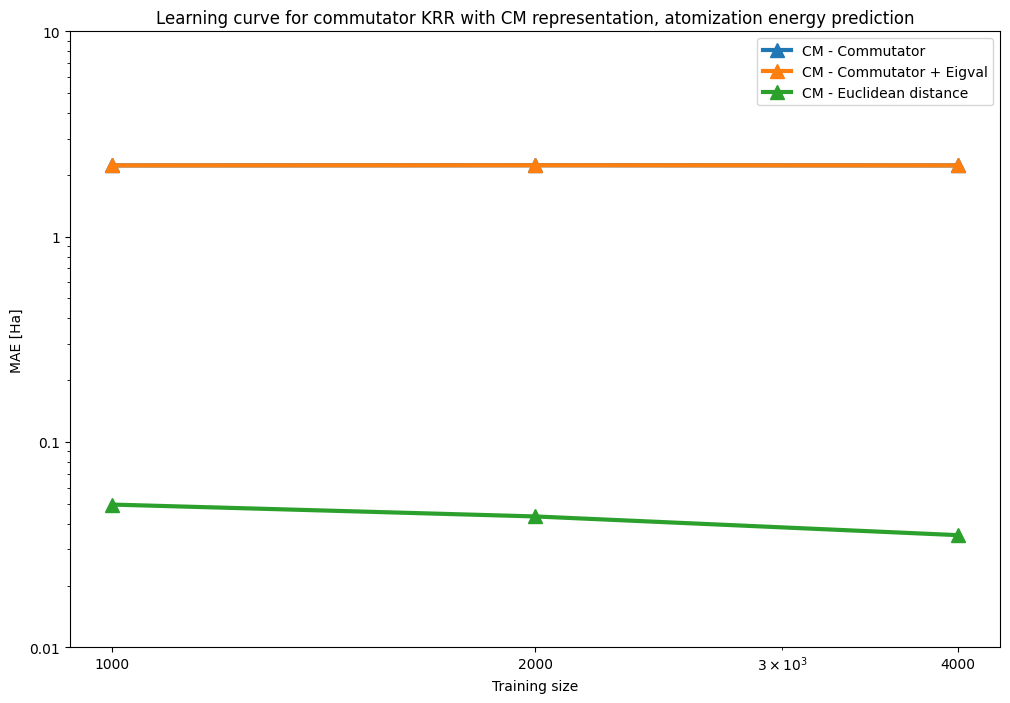

In [10]:
x = training_size
y1 = error1 # [2.223485323750093, 2.227697762000094, 2.223716049000092]
y2 = error2 # [2.223485323750093, 2.227697762000094, 2.223716049000092]
y3 = normal_KRR_error # [0.049585489531661565, 0.0434052070166386, 0.03518850176009182]

plt.figure(figsize=(12, 8))
plt.plot(x, y1, label='CM - Commutator', marker='^', linestyle='-', linewidth=3, markersize=10)
plt.plot(x, y2, label='CM - Commutator + Eigval', marker='^', linestyle='-', linewidth=3, markersize=10)
plt.plot(x, y3, label='CM - Euclidean distance', marker='^', linestyle='-', linewidth=3, markersize=10)

plt.title("Learning curve for commutator KRR with CM representation, atomization energy prediction")
plt.xlabel('Training size')
plt.ylabel('MAE [Ha]')
plt.legend()

plt.xscale('log', base=10)
plt.yscale('log', base=10)
xticks = training_size
yticks = [10, 1, 0.1, 0.01]
plt.xticks(xticks, labels=xticks)
plt.yticks(yticks, labels=yticks)

plt.savefig("Learning_curve.png")
plt.show()


## Distribution ##

In [ ]:
def euclidean_distance(arr, batch_size=500):
    num_rows = arr.shape[0]
    distance_matrix = np.zeros((num_rows, num_rows))

    for i in range(0, num_rows, batch_size):
        end_idx_i = min(i + batch_size, num_rows)
        batch_i = arr[i:end_idx_i]

        for j in range(0, num_rows, batch_size):
            end_idx_j = min(j + batch_size, num_rows)
            batch_j = arr[j:end_idx_j]

            # Calculate squared Euclidean distances between rows in the current batches
            squared_distances = np.sum((batch_i[:, np.newaxis] - batch_j) ** 2, axis=2)

            # Take the square root to get the actual Euclidean distances
            distance_matrix[i:end_idx_i, j:end_idx_j] = np.sqrt(squared_distances)

    return distance_matrix


In [ ]:
euclidean_dist = euclidean_distance(cm_flatten)
print(euclidean_dist.shape)


In [ ]:
flattened_euclidean_dist = euclidean_dist.flatten()
plt.hist(flattened_euclidean_dist, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distances between CM vectors')
plt.grid(True)
plt.savefig("Distribution of Euclidean Distances between CM vectors.png")
plt.show()

## Commutator Distribution ##

In [20]:
def commutator_distance_matrix_batched(arr, batch_size=1000):
    num_matrices = arr.shape[0]
    num_rows = arr.shape[1]
    distance_matrix = np.zeros((num_matrices, num_matrices))

    for i in range(0, num_matrices, batch_size):
        end_idx_i = min(i + batch_size, num_matrices)
        batch_i = arr[i:end_idx_i]

        for j in range(0, num_matrices, batch_size):
            end_idx_j = min(j + batch_size, num_matrices)
            batch_j = arr[j:end_idx_j]

            # Compute the commutator between matrices in the current batches
            commutator = np.matmul(batch_i[:, np.newaxis], batch_j) - np.matmul(batch_j[:, np.newaxis], batch_i)
            
            # Calculate the Frobenius norm of the commutator
            commutator_norm = np.linalg.norm(commutator, ord='fro', axis=(2, 3))

            # Take the square root to get the actual commutator distances
            distance_matrix[i:end_idx_i, j:end_idx_j] = commutator_norm

    return distance_matrix

In [21]:
# Compute the commutator distance matrix for matrices in batches of size 100
commutator_dist = p_distance_commutator(cm[:1000], cm[:1000])
np.fill_diagonal(commutator_dist, np.nan)
print(commutator_dist.shape)

(1000, 1000)


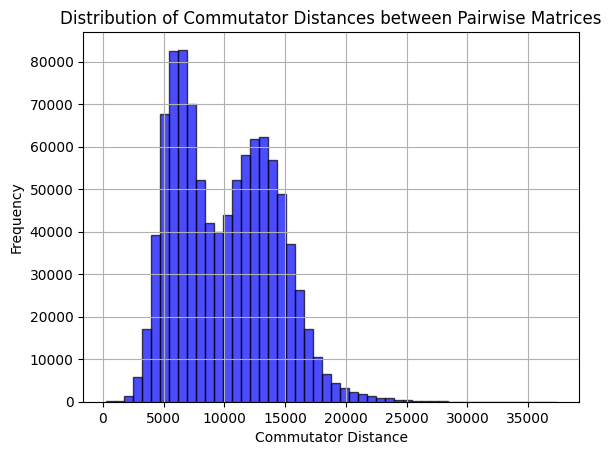

In [24]:
# Flatten the distance matrix into a 1D array
flattened_commutator_dist = commutator_dist.flatten()

# Create a histogram of the flattened distances
plt.hist(flattened_commutator_dist, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Commutator Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Commutator Distances between Pairwise Matrices')
plt.grid(True)
plt.savefig('Distribution of Commutator Distances between Pairwise Matrices')
plt.show()

In [14]:
unique_sorted = np.sort(np.unique(flattened_commutator_dist))
print(unique_sorted[1])

317.4419324785709


In [16]:
zero_mask = (flattened_commutator_dist == 0)
num_zeros = np.count_nonzero(zero_mask)
print(num_zeros)

0


## Commutator With Eigval ##

In [17]:
# eigval_dist = p_distance_eigval(cm[:10], cm[:10])
# eigval_dist_batch = p_distance_eigval_batch(cm[:10], cm[:10], batch_size=2)
# diff_indices = np.where(eigval_dist != eigval_dist_batch)

# for row, col in zip(*diff_indices):
#     print(f"Array1[{row}, {col}] = {eigval_dist[row, col]}")
#     print(f"Array2[{row}, {col}] = {eigval_dist_batch[row, col]}")

In [18]:

eigval_dist = p_distance_eigval_batch(cm[:1000], cm[:1000], batch_size=100)
np.fill_diagonal(eigval_dist, np.nan)
print(eigval_dist.shape)

(1000, 1000)


In [22]:
commutator_plus_eigval_dist = eigval_dist + commutator_dist
print(commutator_plus_eigval_dist.shape)

(1000, 1000)


In [46]:
@numba.jit(nopython=True)
def p_distance_energy(x, y):
    a, b = len(x), len(y)
    mat = np.zeros((a,b))
    for i in range(a):
        for j in range(b):
            mat[i][j] = np.abs(x[i] - y[j])
    return mat

In [49]:
energy_dist = p_distance_energy(energies[:1000], energies[:1000])
np.fill_diagonal(energy_dist, np.nan)
print(energy_dist.shape)
flattened_energy_dist = energy_dist.flatten()
energy_x_label = [flattened_commutator_dist[i] for i in range(len(flattened_energy_dist))]

(1000, 1000)


(0.0, 2.5)

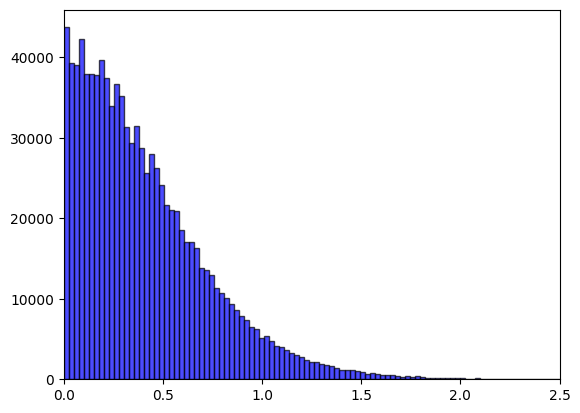

In [54]:
# plt.hist(energies, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.hist(flattened_energy_dist, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlim(0, 2.5)

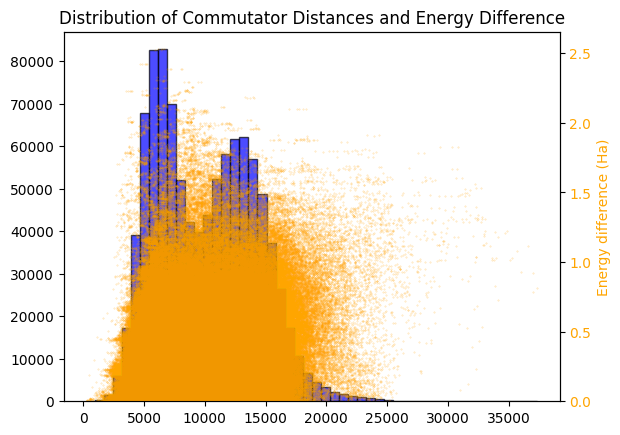

In [61]:
plt.hist(flattened_commutator_dist, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes = plt.twinx()
axes.scatter(energy_x_label,flattened_energy_dist, s=0.1, alpha=0.2, color='orange', label='Energy difference')
axes.set_ylim(bottom=0)
axes.set_ylabel('Energy difference (Ha)', color='orange')
axes.tick_params(axis='y', labelcolor='orange')
plt.title('Distribution of Commutator Distances and Energy Difference')
# plt.grid(True)
plt.savefig('Distribution of Commutator Distances and Energy Difference')
plt.show()

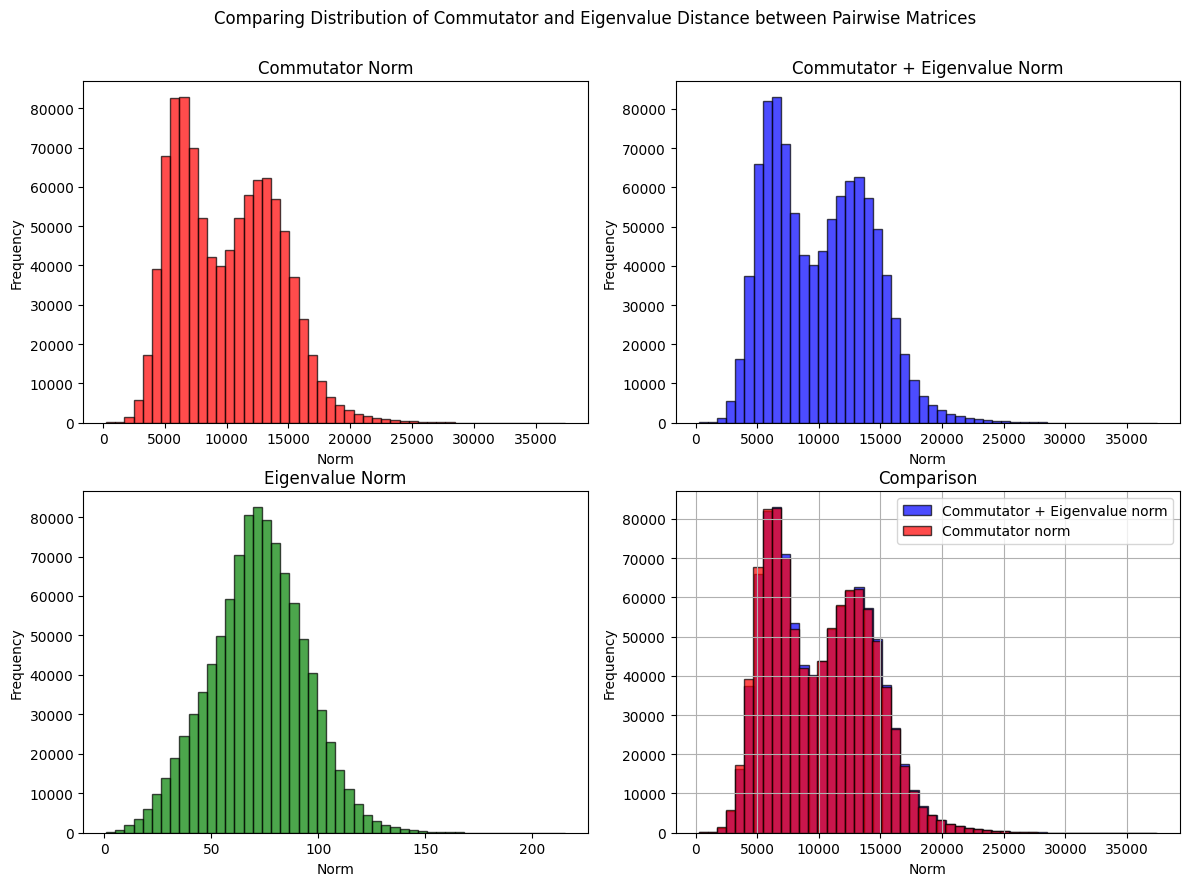

In [64]:
# Flatten the distance matrix into a 1D array
flattened_commutator_plus_eigval_dist = commutator_plus_eigval_dist.flatten()
flattened_eigval_dist = eigval_dist.flatten()

# Create a histogram of the flattened distances
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].hist(flattened_commutator_dist, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].set_title('Commutator Norm')
axes[0, 0].set_xlabel('Norm')
axes[0, 0].set_ylabel('Frequency')
# ax0_twin = axes[0, 0].twinx()
# ax0_twin.scatter(energy_x_label, flattened_energy_dist, s=0.1, alpha=0.2, color='orange', label='Energy difference')
# ax0_twin.set_ylabel('Scatter Plot 1', color='orange')
# ax0_twin.tick_params(axis='y', labelcolor='orange')

axes[0, 1].hist(flattened_commutator_plus_eigval_dist, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title('Commutator + Eigenvalue Norm')
axes[0, 1].set_xlabel('Norm')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(flattened_eigval_dist, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_title('Eigenvalue Norm')
axes[1, 0].set_xlabel('Norm')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(flattened_commutator_plus_eigval_dist, bins=50, alpha=0.7, color='blue', edgecolor='black', label="Commutator + Eigenvalue norm")
axes[1, 1].hist(flattened_commutator_dist, bins=50, alpha=0.7, color='red', edgecolor='black', label="Commutator norm")
axes[1, 1].set_title('Comparison')
axes[1, 1].set_xlabel('Norm')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.suptitle('Comparing Distribution of Commutator and Eigenvalue Distance between Pairwise Matrices')
plt.subplots_adjust(top=0.90, hspace=0.2)
plt.grid(True)
plt.savefig('Comparing Distribution of Commutator and Eigenvalue Distance between Pairwise Matrices')
plt.show()

In [ ]:
# Flatten the distance matrix into a 1D array
flattened_eigval_dist = eigval_dist.flatten()

# Create a histogram of the flattened distances
plt.hist(flattened_eigval_dist, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Eigval Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvalue Distance between Pairwise Matrices')
plt.grid(True)
plt.savefig('Distribution of Eigenvalue Distance between Pairwise Matrices')
plt.show()

In [27]:
zero_mask = (flattened_commutator_dist < 0.1)
num_zeros = np.count_nonzero(zero_mask)
zero_mask_w_eig = (flattened_commutator_plus_eigval_dist < 0.1)
num_zeros_w_eig = np.count_nonzero(zero_mask_w_eig)
print(num_zeros)
print(num_zeros_w_eig)

0
0
